# Example 4: Quantum-to-classical transfer learning.

This is an example of a hybrid network for quantum state classification, developed according to the *quantum-to-classical transfer learning* scheme presented in [1]. 

## The initial pre-trained quantum network

Our starting point is the pre-trained continuous variable (CV) quantum network presented in [_Killoran et al._](https://arxiv.org/abs/1806.06871) [2], _Section IV.D, Experiment C_. The original aim of this network was to encode 7 different 4X4 images, representing the (L,O,T,I,S,J,Z) [_tetrominos_](https://en.wikipedia.org/wiki/Tetromino) (popularized by the video game _Tetris_), in the Fock basis of 7 two-mode quantum states. The input of the quanutm network is one of the following combinations of two-mode coherent states:

\begin{align}
|\varphi_1\rangle &= |\alpha\rangle|\alpha\rangle \\
|\varphi_2\rangle &= |-\alpha\rangle|\alpha\rangle \\
|\varphi_3\rangle &= |\alpha\rangle|-\alpha\rangle \\
|\varphi_4\rangle &= |-\alpha\rangle|-\alpha\rangle \\
|\varphi_5\rangle &= |i \alpha\rangle| i\alpha\rangle \\
|\varphi_6\rangle &= |-i \alpha\rangle|i \alpha\rangle \\
|\varphi_7\rangle &= |i \alpha\rangle|-i \alpha\rangle \\
\end{align}

where the parameter $\alpha=1.4$ is a fixed constant.

The task of the network is to generate an optimal unitary transformation $|\tilde{\varphi}_j\rangle=U|\varphi_j\rangle$, such that the probability of finding $i$ photons in the first mode and $j$ photons in the second mode is proportional to the amplitude of pixel $(i,j)$. More precisely, the network is trained to reproduce the tetromino images after projecting the quantum state on the subspace of up to 3 photons. A simulation of the photon number probability distribution and its renormalized subspace projection, are respectively reported in the first and second row of the following figure (taken from Figure 10 of [_Killoran et al._](https://arxiv.org/abs/1806.06871)) [2].

![Tetromino images encoded in quantum states. ](static/fig_tetrominos_paper.png)

## Quantum-to-classical transfer learning

With respect to the problem above, we are going to change the dataset and the task in order to give proof-of-principle demonstration of the _quantum-to-classical transfer learning_ method.

We assume that the 7 combinations coherent states discussed above are subject to a Gaussian additive noise (random displacements) and that our goal is to correctly guess the original quantum state:

\begin{align}
|\varphi_j & \rangle   \xrightarrow{\text{random displacement}}  \hat D (\delta\alpha_1,\delta\alpha_2)|\varphi_j \rangle \\
&\xrightarrow{\text{quantum-classical network}} \text{Outcome: } \textit{"the state belongs to class } j\text{"}
\end{align}


In a machine learning language this can be seen as a classification problem with 7 classes and a quantum dataset consisting of randomly displaced coherent states.

The starting point of our hybrid model is the CV quantum network presented in the previous section despite it was pre-trained for a quite different task. **The motivation behind this approach is that the image pixels which are produced by the pre-trained network can be considered as classical features possessing a strong correlation with the input state. It is then reasonable to assume that such features can be efficiently post-processed and classified.**

The code presented in the next sections is a practical implementation of this idea, which can be summarized in 4 operational steps:

1. Remove some quantum layers (0, 1, 2, or more) from the previously described pre-trained quantum network.
2. Measure the system in the Fock basis. In this way the quantum circuit acts as a feature extractor.
3. Add some final classical layers to post-process the estimated photon-number probability distribution.
4. Train only such classical layers to classify the input quantum states.

## General setup

The main imported modules are: the `tensorflow` machine learning framework, the quantum CV 
software `strawberryfields` [3] and the python plotting library `matplotlib`. All modules should be correctly installed in the system before running this notebook.

In [2]:
# Plotting
%matplotlib inline
import matplotlib.pyplot as plt

# TensorFlow
import tensorflow as tf

# Strawberryfields (simulation of CV quantum circuits)
import strawberryfields as sf
from strawberryfields.ops import Dgate, BSgate, Kgate, Sgate, Rgate

# Other modules
import numpy as np
import time

# System variables
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # avoid warning messages
os.environ['OMP_NUM_THREADS'] = '1'       # set number of threads.
os.environ['CUDA_VISIBLE_DEVICES'] = '1'  # select the GPU unit.


Setting of the main parameters of the network model and of the training process.<br>

In [3]:
cutoff = 11                           # must be larger than or equal to 3. Optimal value 11.
im_dim = 4                            # subspace dimension
dump = 100                            # loggin period
num_images = 7                        # number of images
disp_clip = 1                         # max displacement
sq_clip = 1                           # max squeezing
kerr_clip = 1                         # max kerr non-linearity          
sdev = 0.1                            # initial variance of random weights
num_test_batches=1000                 # number of test batches used to estimate accuracy

noise_scale = 0.6                     # noise strength (mean deviation of random displacements)
sub_space = True                      # If True, the state is projected in the 0-3 photons subspace.
fine_tune = False                     # If True, also the quantum paramenters alre trained. Suggested value is False.
num_epochs = 1000                     # Number of training iterations (number of batches of 7 quantum states).
q_depth = 15                          # Number of quantum layers (Max=25).         
c_depth = 1                           # Number of classical layers. 
step = 0.01                           # Learning rate
alpha = 1.4                           # Amplitude of coherent states. Note that the quantum network is pre-trained with alpha=1.4.

tf.reset_default_graph()              # reset tensorflow graph. Useful to re-run the code.
tf.set_random_seed(1)                 # tensorflow random seed
rng_data = np.random.RandomState(100) # numpy random seed

## Quantum dataset

We define the quantum dataset consisting in the 7 two-mode coherent input states definied at the beginning of this notebook (same as in [_Killoran et al._](https://arxiv.org/abs/1806.06871)), which here we assume to be subject to random displacements sampled from a Gaussian distribution with zero mean and variance `noise_scale`.

In [4]:
# function which generates a batch of random noise (real values).
def noise_sample():
    return rng_data.normal(scale=noise_scale, size=num_images)

noise_alpha=tf.placeholder(dtype=tf.complex64, shape=[num_images])
noise_beta=tf.placeholder(dtype=tf.complex64, shape=[num_images])

disps_alpha = tf.constant([alpha, -alpha, alpha, -alpha, 1.0j*alpha, -1.0j*alpha, 1.0j*alpha], dtype = tf.complex64) + noise_alpha
disps_beta = tf.constant([alpha, alpha, -alpha, -alpha, 1.0j*alpha, 1.0j*alpha, -1.0j*alpha], dtype = tf.complex64) + noise_beta
        
labels = [0, 1, 2, 3, 4, 5, 6]

# convert labels into TensorFlow format
labels_holder = tf.constant(labels,dtype = tf.int64)

## Loading of pre-trained quantum weights

As discussed in the introduction we make use of a pre-trained CV quantum neural network. Such network, originally presented  [_Killoran et al._](https://arxiv.org/abs/1806.06871), was trained to reproduce tetronomos images. The corresponding optimal weights can be loaded from the numpy file `pre_trained	rained_params.npy` that must be present in the notebook directory.

In [5]:
# loading of pre-trained weights
trained_params_npy = np.load('pre_trained/trained_params.npy')
# conversion into TensorFlow format
trained_params = tf.constant(trained_params_npy)

# initialization of the variational parameters of the quantum circuit defined later.
with tf.name_scope('variables'):
        r1 = tf.get_variable("r1", trainable=fine_tune, initializer=trained_params[0])
        r2 = tf.get_variable("r2", trainable=fine_tune, initializer=trained_params[1])
                
        theta1 = tf.get_variable("theta1", trainable=fine_tune, initializer=trained_params[2])
        phi1 = tf.get_variable("phi1", trainable=fine_tune, initializer=trained_params[3])
                
        theta2 = tf.get_variable("theta2", trainable=fine_tune,initializer=trained_params[4])
        phi2 = tf.get_variable("phi2", trainable=fine_tune, initializer=trained_params[5])

        sqr1 = tf.get_variable("sqr1", trainable=fine_tune, initializer=trained_params[6])
        sqphi1 = tf.get_variable("sqphi1", trainable=fine_tune, initializer=trained_params[7])

        sqr2 = tf.get_variable("sqr2", trainable=fine_tune, initializer=trained_params[8])
        sqphi2 = tf.get_variable("sqphi2", trainable=fine_tune, initializer=trained_params[9])

        dr1 = tf.get_variable("dr1", trainable=fine_tune, initializer=trained_params[10])
        dphi1 = tf.get_variable("dphi1", trainable=fine_tune, initializer=trained_params[11])

        dr2 = tf.get_variable("dr2", trainable=fine_tune, initializer=trained_params[12])
        dphi2 = tf.get_variable("dphi2", trainable=fine_tune, initializer=trained_params[13])

        kappa1 = tf.get_variable("kappa1", trainable=fine_tune, initializer=trained_params[14])
        kappa2 = tf.get_variable("kappa2", trainable=fine_tune, initializer=trained_params[15])

Parameters = [r1, r2, theta1, phi1, theta2, phi2, sqr1, sqphi1, sqr2, sqphi2, dr1, dphi1, dr2, dphi2, kappa1, kappa2]


## Hybrid transfer learning model (quantum-to-classical).

We first instantiate a _StrawberryFields_ quantum simulator, taylored for simulating a two-mode quantum optical system.

In [6]:
prog = sf.Program(2)
eng = sf.Engine('tf', backend_options={'cutoff_dim': cutoff, 'batch_size': num_images})

### First block: pre-trained quantum neural network.

Now we can define, via _StrawberryFields_, the CV quantum neural network model proposed in [_Killoran et al._](https://arxiv.org/abs/1806.06871). 

With respect to the original version of the network which was designed to have 25 variaitonal layers, here we allow for the possibility of applying only a number `q_depth` of such layers (form 0 up to 25). This is motivated by the idea that the final features of a pre-trained network can be too task-specific, while intermediate features can be more suitable for a transfer learning operation.

In [7]:
# Definition of a single variational quantum layer composed of: 
# beam splitters, squeezing, displacements, Kerr non-linearities, etc.

def layer(l):
    with tf.name_scope('layer_{}'.format(l)):
            BSgate(theta1[l], phi1[l]) | (qMode[0], qMode[1])
            Rgate(r1[l]) | qMode[0]

            Sgate(tf.clip_by_value(sqr1[l], -sq_clip, sq_clip), sqphi1[l]) | qMode[0]
            Sgate(tf.clip_by_value(sqr2[l], -sq_clip, sq_clip), sqphi2[l]) | qMode[1]

            BSgate(theta2[l], phi2[l]) | (qMode[0], qMode[1])
            Rgate(r2[l]) | qMode[0]

            Dgate(tf.clip_by_value(dr1[l], -disp_clip, disp_clip), dphi1[l]) | qMode[0]
            Dgate(tf.clip_by_value(dr2[l], -disp_clip, disp_clip), dphi2[l]) | qMode[1]

            Kgate(tf.clip_by_value(kappa1[l], -kerr_clip, kerr_clip)) | qMode[0]
            Kgate(tf.clip_by_value(kappa2[l], -kerr_clip, kerr_clip)) | qMode[1]

# Definition of the complete quantum circuit: state preparation + quantum layers
with prog.context as qMode:
        Dgate(disps_alpha) | qMode[0]
        Dgate(disps_beta)  | qMode[1]
        for i in range(q_depth):
                layer(i)
                
# Simulation of the quantum state evolution 
results = eng.run(prog, run_options={"eval": False})  
ket = results.state.ket()

# Projection on the subspace of up to im_dim-1 photons for each mode.
ket_reduced = ket[:, :im_dim, :im_dim]
norm = tf.sqrt(tf.abs(tf.reduce_sum(tf.conj(ket_reduced) * ket_reduced, axis=[1, 2])))

# Since norm has shape [num_images] while ket_reduced has shape [num_images,im_dim,im_dim]
# we need to add 2 extra dimensions to the norm tensor.
norm_extended = tf.reshape(norm, [num_images, 1, 1])
ket_processed = ket_reduced / tf.cast(norm_extended, dtype=tf.complex64)

# Convert the state coefficients into images for features visualization.
images_out = tf.abs(ket_processed) ** 2
images_out_big = tf.abs(ket) ** 2

# Definition of the classical output of the quantum circuit, i.e. the probabilities of photon number detections.
if sub_space == True:
        ket_abs =  tf.abs(ket_processed)
        num_features = (cutoff + 1) * (cutoff + 1)
else:
        ket_abs = tf.abs(ket)
        num_features = im_dim * im_dim
        
# Flatten to get a classical vector of features
ket_abs_flatten = tf.contrib.layers.flatten(ket_abs)

### Second block: trainable classical network.
By following the transfer learning method, we connect the pre-trained quantum block to a final trainable classical network. Depending on the parameter `c_depth`, the classical block is a simple linear classfier (if `c_depth` is 1) or a more complex neural network with `c_depth` dense layers and non-linear activations (_ReLU_). 

In [8]:
# sequence of fully connected classical layers  
c_in = ket_abs_flatten
for _ in range(c_depth - 1):
        c_in = tf.contrib.layers.fully_connected(c_in,num_features, activation_fn=tf.nn.relu)
c_out = tf.contrib.layers.fully_connected(c_in, num_images, activation_fn=None) 

### Loss function, accuracy, and optimizer.

In [9]:
# Definition of the loss function to minimize
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = labels_holder, logits = c_out))
# Convert logits to labels
predictions = tf.argmax(c_out, 1)
# Batch accuracy
accuracy = tf.reduce_mean(tf.cast(tf.equal(predictions, labels_holder), tf.float32))
# Optimization algorithm
optim = tf.train.AdamOptimizer(learning_rate=step)
training = optim.minimize(loss)

## Training and testing

Up to now we just defined the analytic graph of the hybrid network without evaluating it. Now, after initializing a _TensorFlow session_, we can finally run the actual training and testing phases. 

In [10]:
saver = tf.train.Saver()

test_accuracy = 0.0
train_loss = 0.0
test_loss = 0.0
train_loss_sum = 0.0
test_loss_sum = 0.0
train_accuracy_sum = 0.0
test_accuracy_sum = 0.0

with tf.Session() as sess:
                sess.run(tf.global_variables_initializer())
                         
                #### training phase ####
                for i in range(num_epochs):
                        # generate random displacements
                        noise_dict = {noise_alpha: noise_sample() + 1.0j * noise_sample(), noise_beta: noise_sample() + 1.0j * noise_sample()}
                        rep_time = time.time()
                        [_training,_loss,_accuracy] = sess.run([training, loss, accuracy], feed_dict=noise_dict)
                        train_loss_sum += _loss
                        train_loss = train_loss_sum / (i + 1)
                        train_accuracy_sum += _accuracy
                        train_accuracy = train_accuracy_sum / (i + 1)
                        if (i % dump == 0) and (i != 0):
                                print('Train batch: {:d}, Running loss: {:.3f}, Running accuracy {:.3f}, Single batch time {:.3f}'.format(i,train_loss,train_accuracy,time.time()-rep_time))

                #### test phase ####
                for i in range(num_test_batches):
                        # generate random displacements
                        noise_dict = {noise_alpha: noise_sample() + 1.0j * noise_sample(), noise_beta: noise_sample() + 1.0j * noise_sample()}
                        rep_time = time.time()
                        [_loss,_accuracy] = sess.run([loss,accuracy], feed_dict = noise_dict)   ## same as before without training
                        test_loss_sum += _loss
                        test_loss = test_loss_sum / (i + 1)
                        test_accuracy_sum += _accuracy
                        test_accuracy = test_accuracy_sum / (i + 1)
                        if (i % dump == 0) and (i != 0):
                                print('Test batch: {:d}, Running loss: {:.3f}, Running accuracy {:.3f}, Single batch time {:.3f}'.format(i,test_loss,test_accuracy,time.time()-rep_time))
                
                #### Save model to file ####
                save_path = saver.save(sess, "./model_q2c.ckpt")
                print("Model saved in path: %s" % save_path)

print('Training and testing phases completed.')
print('RESULTS:')
print('{:>11s}{:>11s}{:>11s}{:>11s}'.format('train_loss', 'train_acc', 'test_loss', 'test_acc'))
print('{:11f}{:11f}{:11f}{:11f}'.format(train_loss, train_accuracy, test_loss, test_accuracy))
        
       

Train batch: 100, Running loss: 1.726, Running accuracy 0.463, Single batch time 2.248
Train batch: 200, Running loss: 1.541, Running accuracy 0.579, Single batch time 2.131
Train batch: 300, Running loss: 1.411, Running accuracy 0.635, Single batch time 2.248
Train batch: 400, Running loss: 1.310, Running accuracy 0.666, Single batch time 2.081
Train batch: 500, Running loss: 1.232, Running accuracy 0.692, Single batch time 2.230
Train batch: 600, Running loss: 1.171, Running accuracy 0.710, Single batch time 2.262
Train batch: 700, Running loss: 1.120, Running accuracy 0.720, Single batch time 2.155
Train batch: 800, Running loss: 1.087, Running accuracy 0.726, Single batch time 2.549
Train batch: 900, Running loss: 1.049, Running accuracy 0.735, Single batch time 2.011
Test batch: 100, Running loss: 0.721, Running accuracy 0.806, Single batch time 2.006
Test batch: 200, Running loss: 0.734, Running accuracy 0.804, Single batch time 3.440
Test batch: 300, Running loss: 0.738, Running

## Load model and visualize predictions

In [10]:
saver = tf.train.Saver()
with tf.Session() as sess:
                # Restore variables from disk.
                saver.restore(sess, "./model_q2c.ckpt")
                print("Model restored.")
                
                noise_dict={noise_alpha: noise_sample() + 1.0j * noise_sample(), noise_beta: noise_sample() + 1.0j * noise_sample()}
                [_predictions, _images_out, _images_out_big] = sess.run([predictions, images_out, images_out_big], feed_dict=noise_dict) 

INFO:tensorflow:Restoring parameters from ./model_q2c.ckpt
Model restored.


Now we represent the Fock state probabilities as 4X4 images. These are the _features_ extracted by the quantum network and successively processed and classified by by the final classical network. 

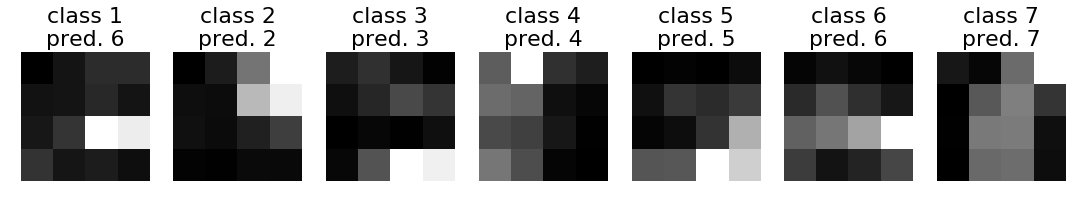

In [11]:
# plot features as images
fig, axs = plt.subplots(nrows=1, ncols=7, figsize = (15, 3))
for idx, ax in enumerate(axs.flat):
    ax.axis('off')
    if idx < 7:
        ax.imshow(_images_out[idx], cmap='gray')
        ax.set_title('class ' + str(idx + 1) + '\n' + 'pred. ' + str(_predictions[idx] + 1) , fontsize=22)
    #else:
    #    ax.imshow(_KetImageOutBig[idx-7], cmap='gray')
plt.tight_layout()
plt.show() 

## References

[1] Andrea Mari, Thomas R. Bromley, Josh Izaac, Maria Schuld, and Nathan Killoran. _Transfer learning in hybrid classical-quantum neural networks_. [arXiv:xxxx.xxxx](https://arxiv.org/abs/xxxx.xxxx), (2019).

[2] Nathan Killoran, Thomas R. Bromley, Juan Miguel Arrazola, Maria Schuld, Nicolás Quesada, and Seth Lloyd. _Continuous-variable quantum neural networks_. [arXiv:1806.06871](https://arxiv.org/abs/1806.06871), (2018).

[3] Nathan Killoran, Josh Izaac, Nicolás Quesada, Ville Bergholm, Matthew Amy, and Christian Weedbrook. _Strawberry Fields: A Software Platform for Photonic Quantum Computing_. [Quantum, 3, 129 (2019)](https://doi.org/10.22331/q-2019-03-11-129).